This project is an exploration of recommendation engine methods applied to two public datasets from Kaggle:<br>
- **the [book recommendation dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset): content-based and collaborative filtering**,
- the [the groceries dataset](https://www.kaggle.com/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba): association rules-based recommendations (see the market-basket-recommender notebook).

# 0. Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy
from sklearn.cluster import KMeans
from scipy.sparse import coo_matrix
from numpy.linalg import norm

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
books = pd.read_csv('Books.csv', dtype = 'object')
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [4]:
books.set_index('ISBN', inplace = True)
books.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
ISBN,,,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
users = pd.read_csv('Users.csv', dtype={'User-ID': 'object', 'Location': 'object', 'Age': 'float64'})
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  object 
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.4+ MB


In [6]:
users = pd.read_csv('Users.csv')
users.set_index('User-ID', inplace = True)
users.head()

,Location,Age
User-ID,,
1,"nyc, new york, usa",NaN
2,"stockton, california, usa",18.0
3,"moscow, yukon territory, russia",NaN
4,"porto, v.n.gaia, portugal",17.0
5,"farnborough, hants, united kingdom",NaN


In [7]:
ratings = pd.read_csv('Ratings.csv', dtype= {'User-ID': 'object', 'ISBN': 'object', 'Book-Rating': 'int64'})
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  object
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


In [8]:
ratings['Book-Rating'] = ratings['Book-Rating'].apply(lambda x: np.nan if x == 0 else x) # replacing 0's with Nans because zeros do not really represent valid ratings
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,NaN
1,276726,0155061224,5.0
2,276727,0446520802,NaN
3,276729,052165615X,3.0
4,276729,0521795028,6.0


## 2. EDA

### 2.1. Users by location and age

In [9]:
users['Country'] = users['Location'].apply(lambda x: x.split(', ')[-1])
users['State'] = users['Location'].apply(lambda x: x.split(', ')[-2] if x.find(",")>0 else "n/a")
users['City'] = users['Location'].apply(lambda x: x.split(', ')[-3] if x.count(", ")>1 else "n/a")

In [10]:
users_by_country = users.groupby('Country')['Location'].count().reset_index()
users_by_country.sort_values('Location', ascending = False, inplace = True)
users_by_country.rename(columns = {'Location': 'Num_users'}, inplace = True)
users_by_country['Cum_perc'] = users_by_country['Num_users'].cumsum()/users_by_country['Num_users'].sum()
users_by_country.head(10)

,Country,Num_users,Cum_perc
1052,usa,139711,0.501011
180,canada,21658,0.578678
1034,united kingdom,18538,0.645156
361,germany,17043,0.706273
920,spain,13147,0.753419
75,australia,11784,0.795677
468,italy,11266,0.836078
342,france,3455,0.848468
788,portugal,3325,0.860391
669,new zealand,3097,0.871497


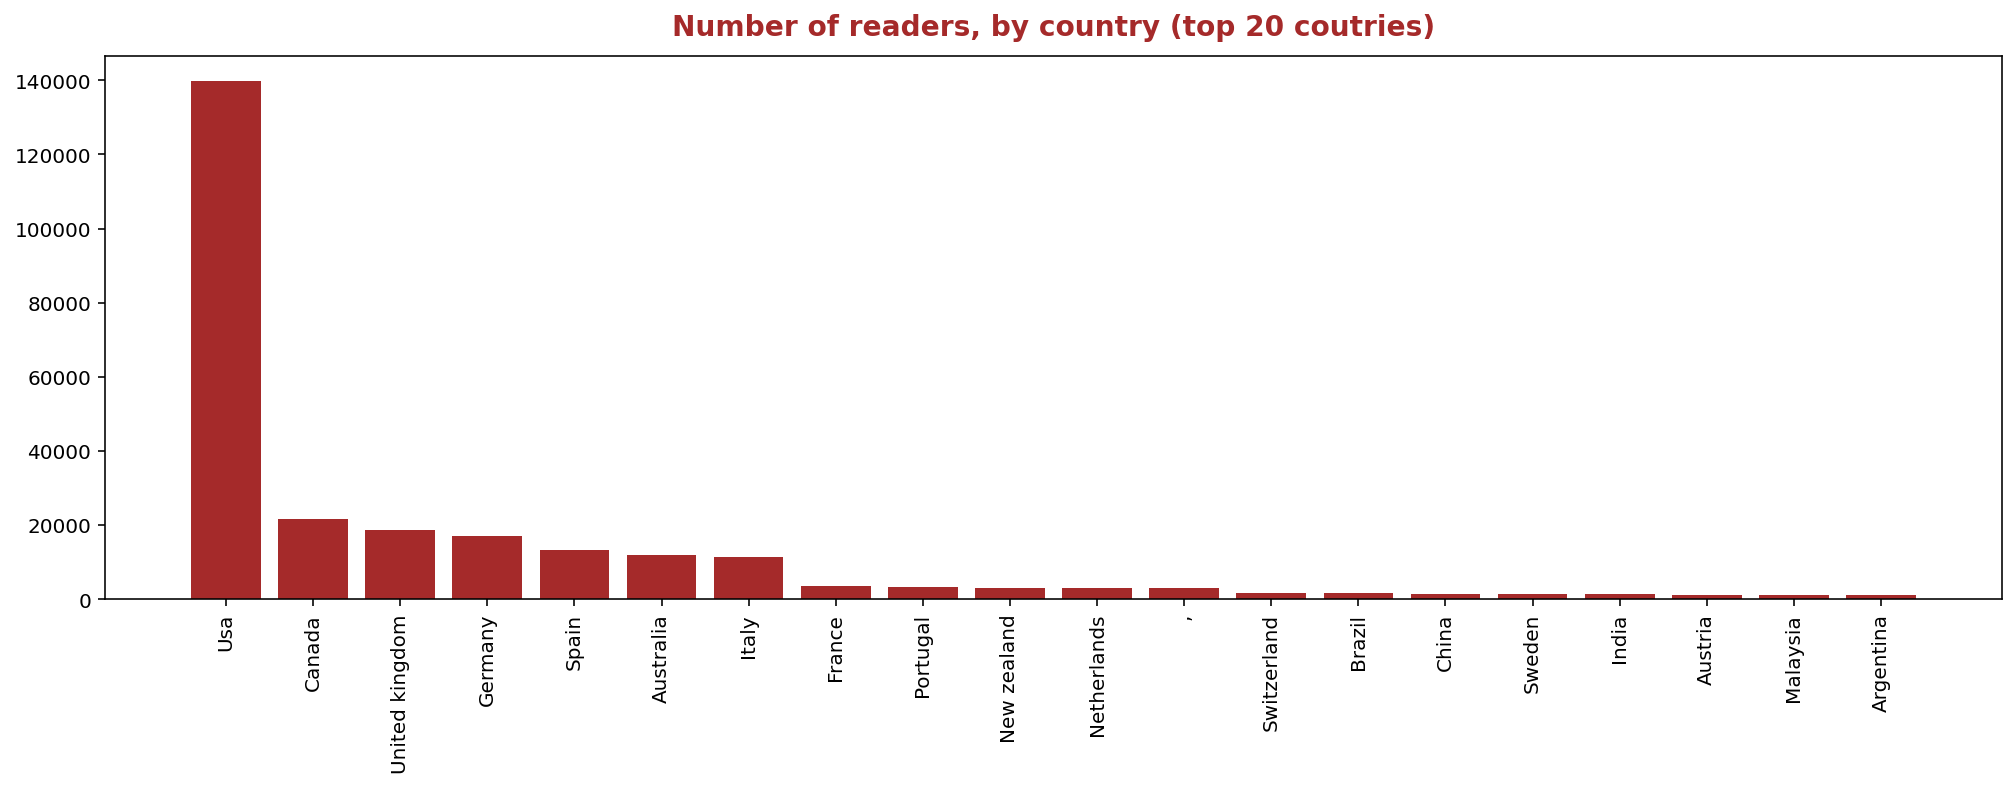

In [11]:
plt.figure(figsize = (17,5))
plt.bar(range(20), users_by_country['Num_users'][:20], color = 'brown')
plt.title('Number of readers, by country (top 20 coutries)', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.xticks(range(20), [cntry.capitalize() for cntry in users_by_country['Country']], rotation = 90);

The dataset is dominated by English-speaking countries.

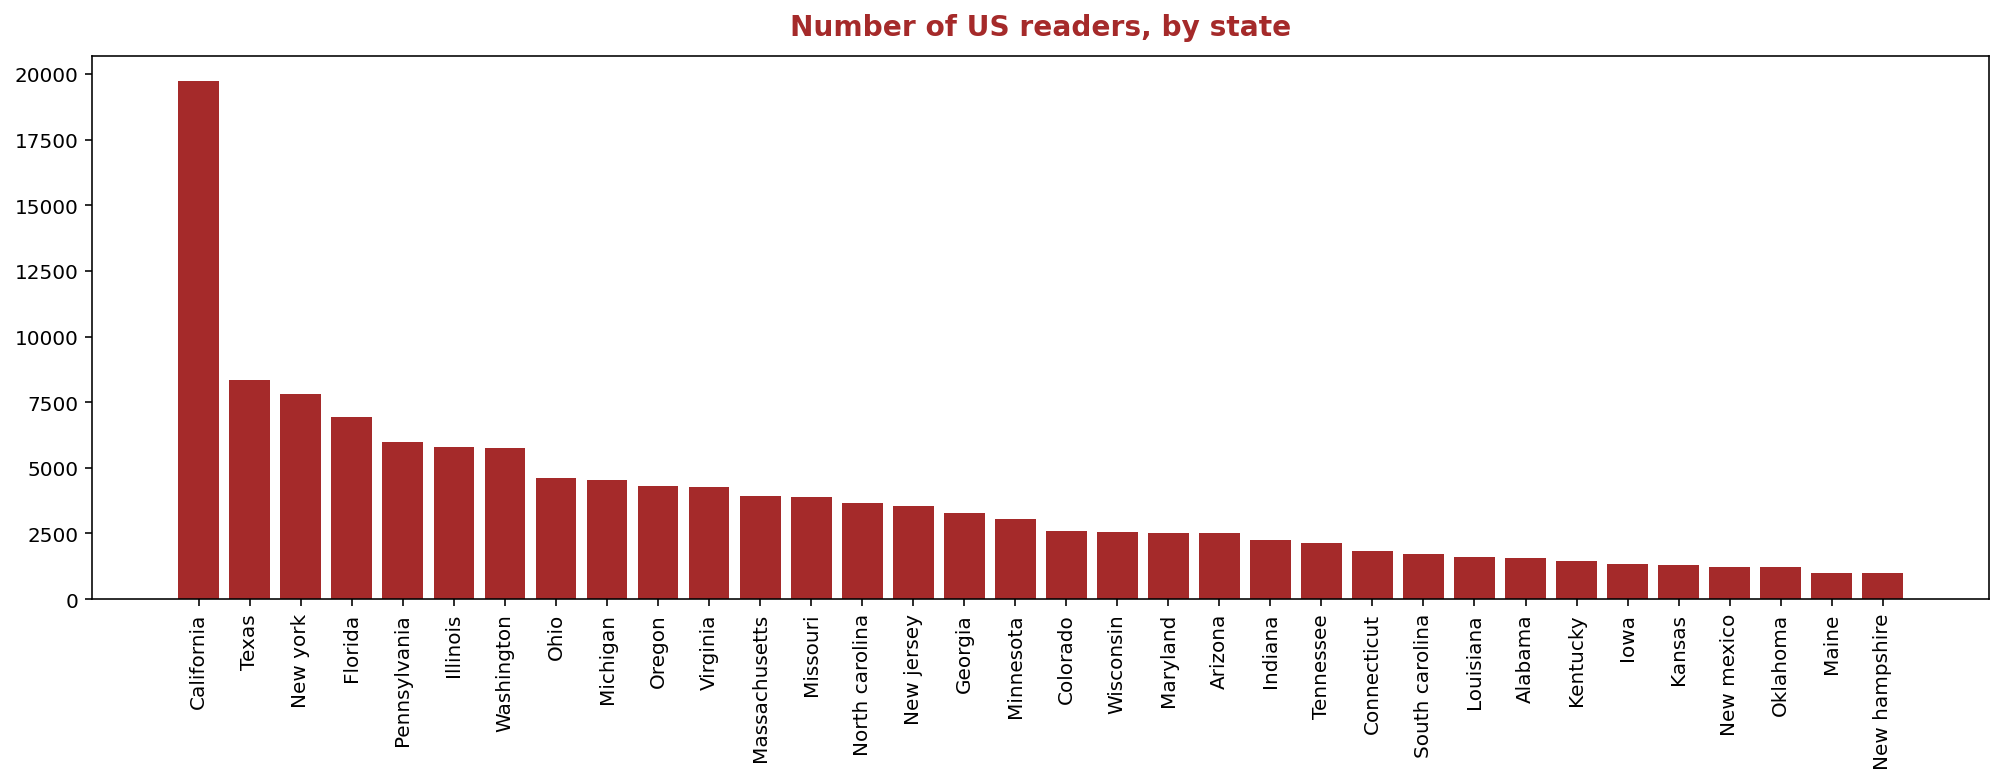

In [12]:
USers_by_state = users[users['Country']=='usa'].groupby('State')['Location'].count().reset_index()
USers_by_state.sort_values('Location', ascending = False, inplace = True)
USers_by_state = USers_by_state[USers_by_state['Location']>1000]

plt.figure(figsize = (17,5))
plt.bar(range(USers_by_state.shape[0]), USers_by_state['Location'], color = 'brown')
plt.title('Number of US readers, by state', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.xticks(range(USers_by_state.shape[0]), [state.capitalize() for state in USers_by_state['State']], rotation = 90);

Most readers in the dataset represent states with the highest populations: California, Texas, and Florida.

### 2.2. Book ratings

In [13]:
ratings['User-ID'] = pd.to_numeric(ratings['User-ID'])

In [14]:
books['Book-Title'] = books['Book-Title'].apply(lambda x: x.replace("&amp;", "&"))
books['Book-Title'] = books['Book-Title'].apply(lambda x: x.split("(")[0])

In [15]:
ratings_w_info = ratings.merge(books[['Book-Title', 'Book-Author']], left_on = 'ISBN', right_index = True)
ratings_w_info = ratings_w_info.merge(users[['Country', 'State']], left_on = 'User-ID', right_index = True)

ratings_w_info.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Country,State
0,276725,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,usa,texas
15433,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,usa,ohio
15456,2313,0812533550,9.0,Ender's Game,Orson Scott Card,usa,ohio
15451,2313,0679745580,8.0,In Cold Blood,TRUMAN CAPOTE,usa,ohio
15426,2313,0060173289,9.0,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,usa,ohio


In [16]:
book_summary = ratings_w_info.groupby(['Country','Book-Title']).agg({"Book-Rating": [np.mean, np.sum], "User-ID": [np.ma.count]}).reset_index()
#book_summary.head()
book_summary.columns = ['Country', 'Book-Title','Avg-Rating','Sum-Ratings','Read-By']
book_summary.sort_values('Read-By', ascending = False).head()

,Country,Book-Title,Avg-Rating,Sum-Ratings,Read-By
344532,usa,Wild Animus,4.324415,1293.0,1201
315671,usa,The Lovely Bones: A Novel,8.188324,4348.0,934
231598,usa,Harry Potter and the Sorcerer's Stone,8.992908,3804.0,735
305547,usa,The Da Vinci Code,8.471033,3363.0,712
179295,usa,A Painted House,7.448387,2309.0,704


In [17]:
most_read_global = book_summary.groupby('Book-Title')['Read-By'].sum().reset_index()
most_read_global.sort_values('Read-By', ascending = False, inplace = True)
most_read_global.head()

,Book-Title,Read-By
227819,Wild Animus,2502
190474,The Lovely Bones: A Novel,1295
154624,She's Come Undone,914
178116,The Da Vinci Code,898
78135,Harry Potter and the Sorcerer's Stone,869


In [18]:
most_read_not_us = book_summary[book_summary['Country']!='usa'].groupby('Book-Title')['Read-By'].sum().reset_index()
most_read_not_us.sort_values('Read-By', ascending = False, inplace = True)
most_read_not_us.head()

,Book-Title,Read-By
108532,Wild Animus,1301
91217,The Lovely Bones: A Novel,361
12065,Bridget Jones's Diary,297
75008,She's Come Undone,226
52011,Life of Pi,201


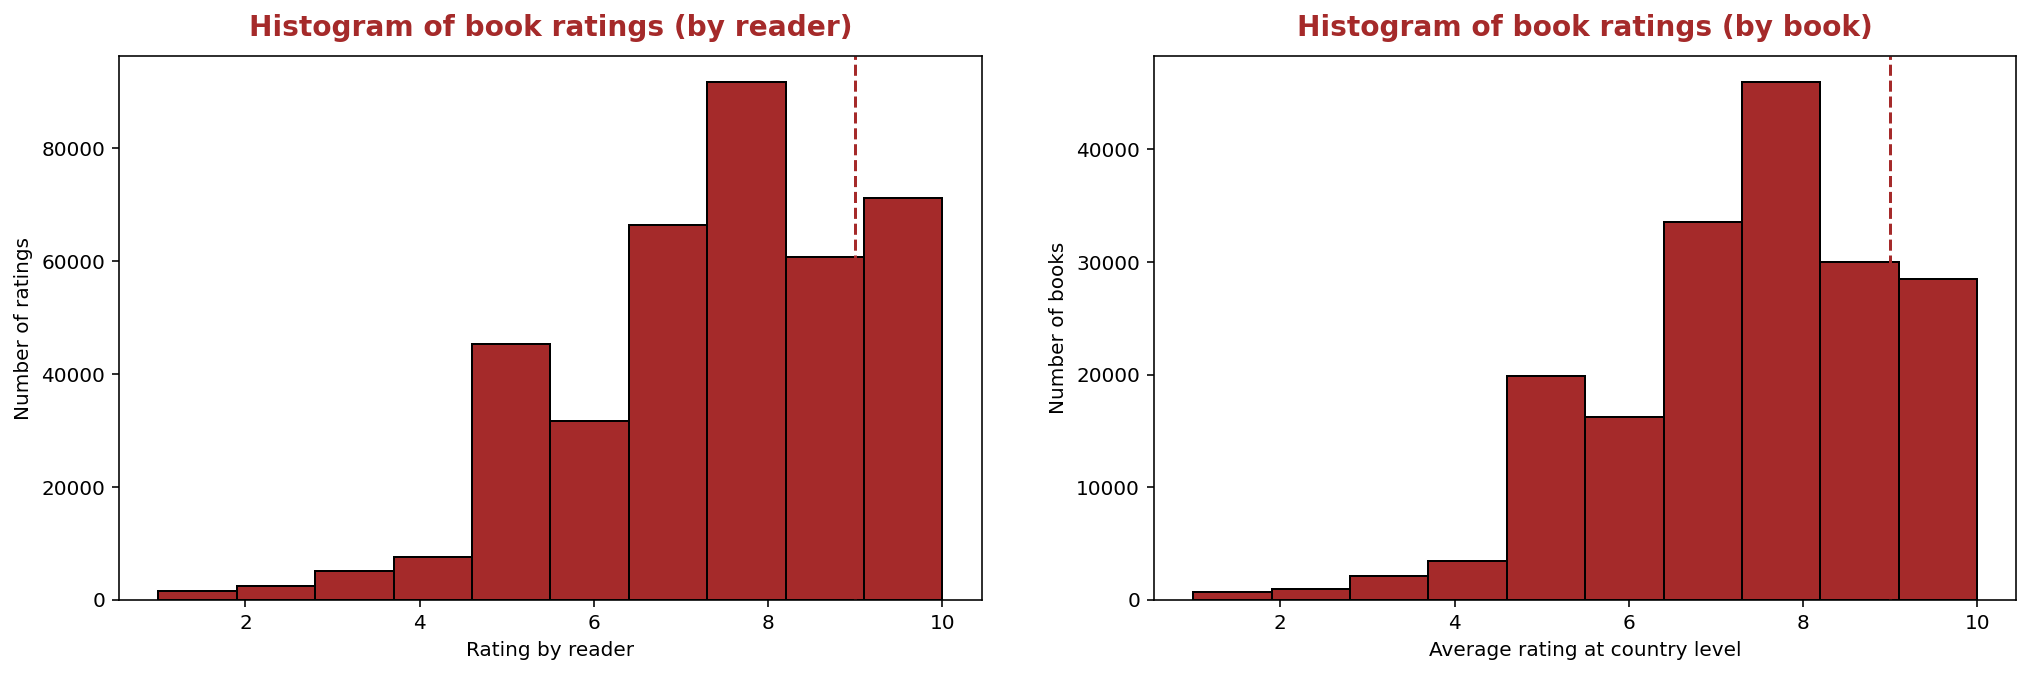

In [19]:
plt.figure(figsize = (17,5))
plt.subplot(1,2,1)
plt.hist(ratings_w_info['Book-Rating'], bins = 10,color='brown', edgecolor = 'black')
plt.title('Histogram of book ratings (by reader)', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.axvline(ratings_w_info['Book-Rating'].quantile(0.75), ls = '--', color = 'brown', )
plt.ylabel('Number of ratings')
plt.xlabel('Rating by reader')
plt.subplot(1,2,2)
plt.hist(book_summary['Avg-Rating'], bins = 10,color='brown', edgecolor = 'black')
plt.title('Histogram of book ratings (by book)', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.axvline(book_summary['Avg-Rating'].quantile(0.75), ls = '--', color = 'brown', )
plt.ylabel('Number of books')
plt.xlabel('Average rating at country level');

### 2.3. Book preferences by country/state

In [20]:
most_read_by_cntry = ratings_w_info.groupby(['Country','Book-Title'])['User-ID'].count().reset_index().sort_values('User-ID', ascending = False)
ref = most_read_by_cntry.groupby('Country')['User-ID'].max()
most_read_by_cntry = most_read_by_cntry[most_read_by_cntry.apply(lambda x: x['User-ID'] == ref[x.Country] , axis = 1)]

most_read_by_cntry.head(10)

,Country,Book-Title,User-ID
344532,usa,Wild Animus,1201
73968,canada,Wild Animus,235
24649,australia,Wild Animus,210
173943,united kingdom,Wild Animus,203
99391,germany,Wild Animus,141
150355,spain,Wild Animus,72
9820,",",The Lovely Bones: A Novel,48
138590,portugal,Wild Animus,47
131809,new zealand,Wild Animus,44
104871,italy,"Novocento, Un Monologo",44


In [21]:
top10_countries = list(most_read_by_cntry['Country'][:11])
top10_countries.remove(",")
top10_countries

['usa',
 'canada',
 'australia',
 'united kingdom',
 'germany',
 'spain',
 'portugal',
 'new zealand',
 'italy',
 'france']

In [22]:
ratings_w_info.head()
ratings_w_info_summ = ratings_w_info.groupby('Book-Title')['Book-Rating'].agg([np.mean, np.ma.count])
ratings_w_info_summ.columns = ['Avg-Rating', 'Count-Ratings']
ratings_w_info_summ.sort_values(['Avg-Rating', 'Count-Ratings'], ascending = False, inplace = True)
ratings_w_info_summ.head()

,Avg-Rating,Count-Ratings
Book-Title,,
Natural California: A Postcard Book,10.0,26.0
Roseanne: My Life As a Woman,10.0,26.0
Postmarked Yesteryear: 30 Rare Holiday Postcards,10.0,21.0
Relationship Rescue: A Seven Step Strategy for Reconnecting with Your Partner,10.0,20.0
Someone To Protect Her,10.0,19.0


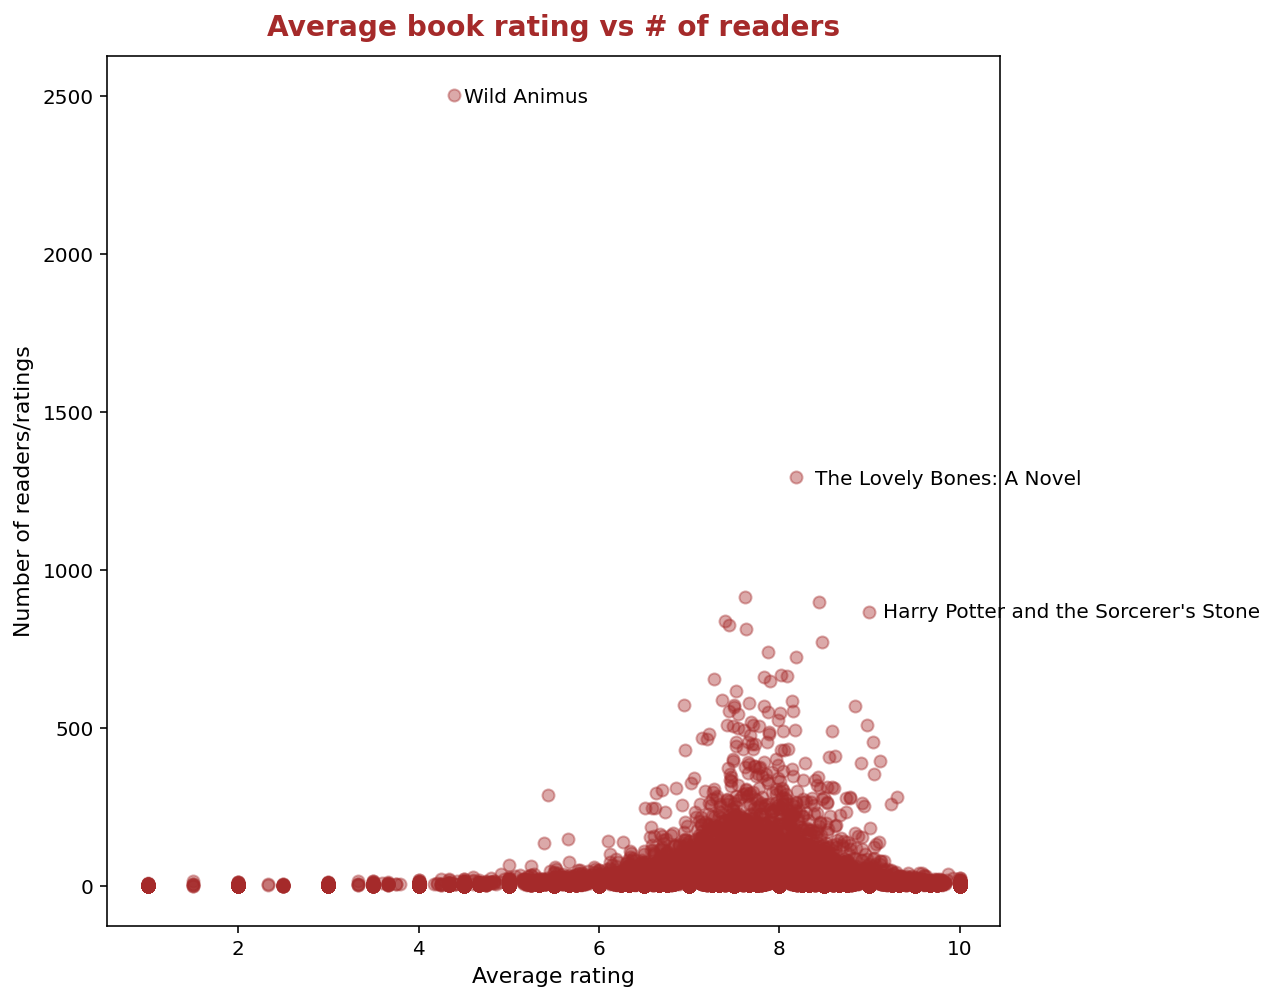

In [23]:
plt.figure(figsize = (8,8))
plt.scatter(ratings_w_info_summ['Avg-Rating'], ratings_w_info_summ['Count-Ratings'], color = 'brown', alpha = 0.4)
plt.title('Average book rating vs # of readers', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.xlabel('Average rating', fontdict = {'fontsize': 11})
plt.ylabel('Number of readers/ratings', fontdict = {'fontsize': 11})
plt.text(4.5,2480, str(ratings_w_info_summ[ratings_w_info_summ['Count-Ratings']>2000].index[0]))
plt.text(8.4,1270, str(ratings_w_info_summ[ratings_w_info_summ['Count-Ratings'].between(1200,2000)].index[0]));
plt.text(9.15,850, str(ratings_w_info_summ[ratings_w_info_summ['Count-Ratings'].between(800,900)].index[0]));

In [24]:
# reference table to determine which books to show in summary of "highest rated books by country" (counts all books rated 7 or above in countries listed as top 10)
highest_rated_by_cntry = book_summary[(book_summary['Avg-Rating']>=7) & (book_summary['Country'].isin(top10_countries))].groupby(['Country', 'Book-Title']).agg({'Read-By': np.sum, 'Avg-Rating': np.mean}).reset_index()
highest_rated_by_cntry.columns = ['Country', 'Book-Title', 'Read-By', 'Avg-Rating']
highest_rated_by_cntry.sort_values(['Country','Read-By'],ascending = False, inplace = True)
highest_rated_by_cntry['max'] = abs((highest_rated_by_cntry['Country'].shift() == highest_rated_by_cntry['Country']).astype(int)-1) # puts 1 where country (in a set sorted by descending count of readers) is listed for the first time - meaning max value
highest_rated_by_cntry = highest_rated_by_cntry[highest_rated_by_cntry['max']==1]
highest_rated_by_cntry

,Country,Book-Title,Read-By,Avg-Rating,max
98227,usa,The Lovely Bones: A Novel,934,8.188324,1
36689,united kingdom,Bridget Jones's Diary,110,7.727273,1
34578,spain,New Vegetarian: Bold and Beautiful Recipes for...,35,9.000000,1
31759,portugal,The Da Vinci Code,21,7.833333,1
29382,new zealand,Life of Pi,11,8.714286,1
28639,italy,"Novocento, Un Monologo",44,8.736842,1
23850,germany,Der Vorleser,45,7.857143,1
20843,france,Je Voudrais Que Quelqu'un M'Attende Quelque Part,32,7.666667,1
14174,canada,She's Come Undone,141,7.661538,1
1858,australia,Memoirs of a Geisha Uk,42,8.040000,1


In [25]:
book_summary_us = ratings_w_info[ratings_w_info['Country']=='usa'].groupby(['State','Book-Title']).agg({"Book-Rating": [np.mean, np.sum], "User-ID": [np.ma.count]}).reset_index()
book_summary_us.head()
book_summary_us.columns = ['State', 'Book-Title','Avg-Rating','Sum-Ratings','Read-By']
book_summary_us.sort_values('Read-By', ascending = False).head()

,State,Book-Title,Avg-Rating,Sum-Ratings,Read-By
76958,california,Wild Animus,4.300000,172.0,160
68716,california,The Lovely Bones: A Novel,8.220779,633.0,128
69371,california,The Nanny Diaries: A Novel,7.536232,520.0,128
45085,california,Harry Potter and the Sorcerer's Stone,8.937500,572.0,120
71029,california,The Secret Life of Bees,8.016949,473.0,119


In [26]:
# reference table to determine which books to show in summary of "highest rated books by state" (counts all books rated 7 or above in USA)
highest_rated_by_state = book_summary_us[book_summary_us['Avg-Rating']>=7].groupby(['State', 'Book-Title']).agg({'Read-By': np.sum, 'Avg-Rating': np.mean}).reset_index()
highest_rated_by_state.columns = ['State', 'Book-Title', 'Read-By', 'Avg-Rating']
highest_rated_by_state.sort_values(['State','Read-By'],ascending = False, inplace = True)
highest_rated_by_state['max'] = abs((highest_rated_by_state['State'].shift() == highest_rated_by_state['State']).astype(int)-1) # puts 1 where country (in a set sorted by descending count of readers) is listed for the first time - meaning max value
highest_rated_by_state = highest_rated_by_state[highest_rated_by_state['max']==1]
highest_rated_by_state.sort_values('Read-By', ascending = False, inplace = True)

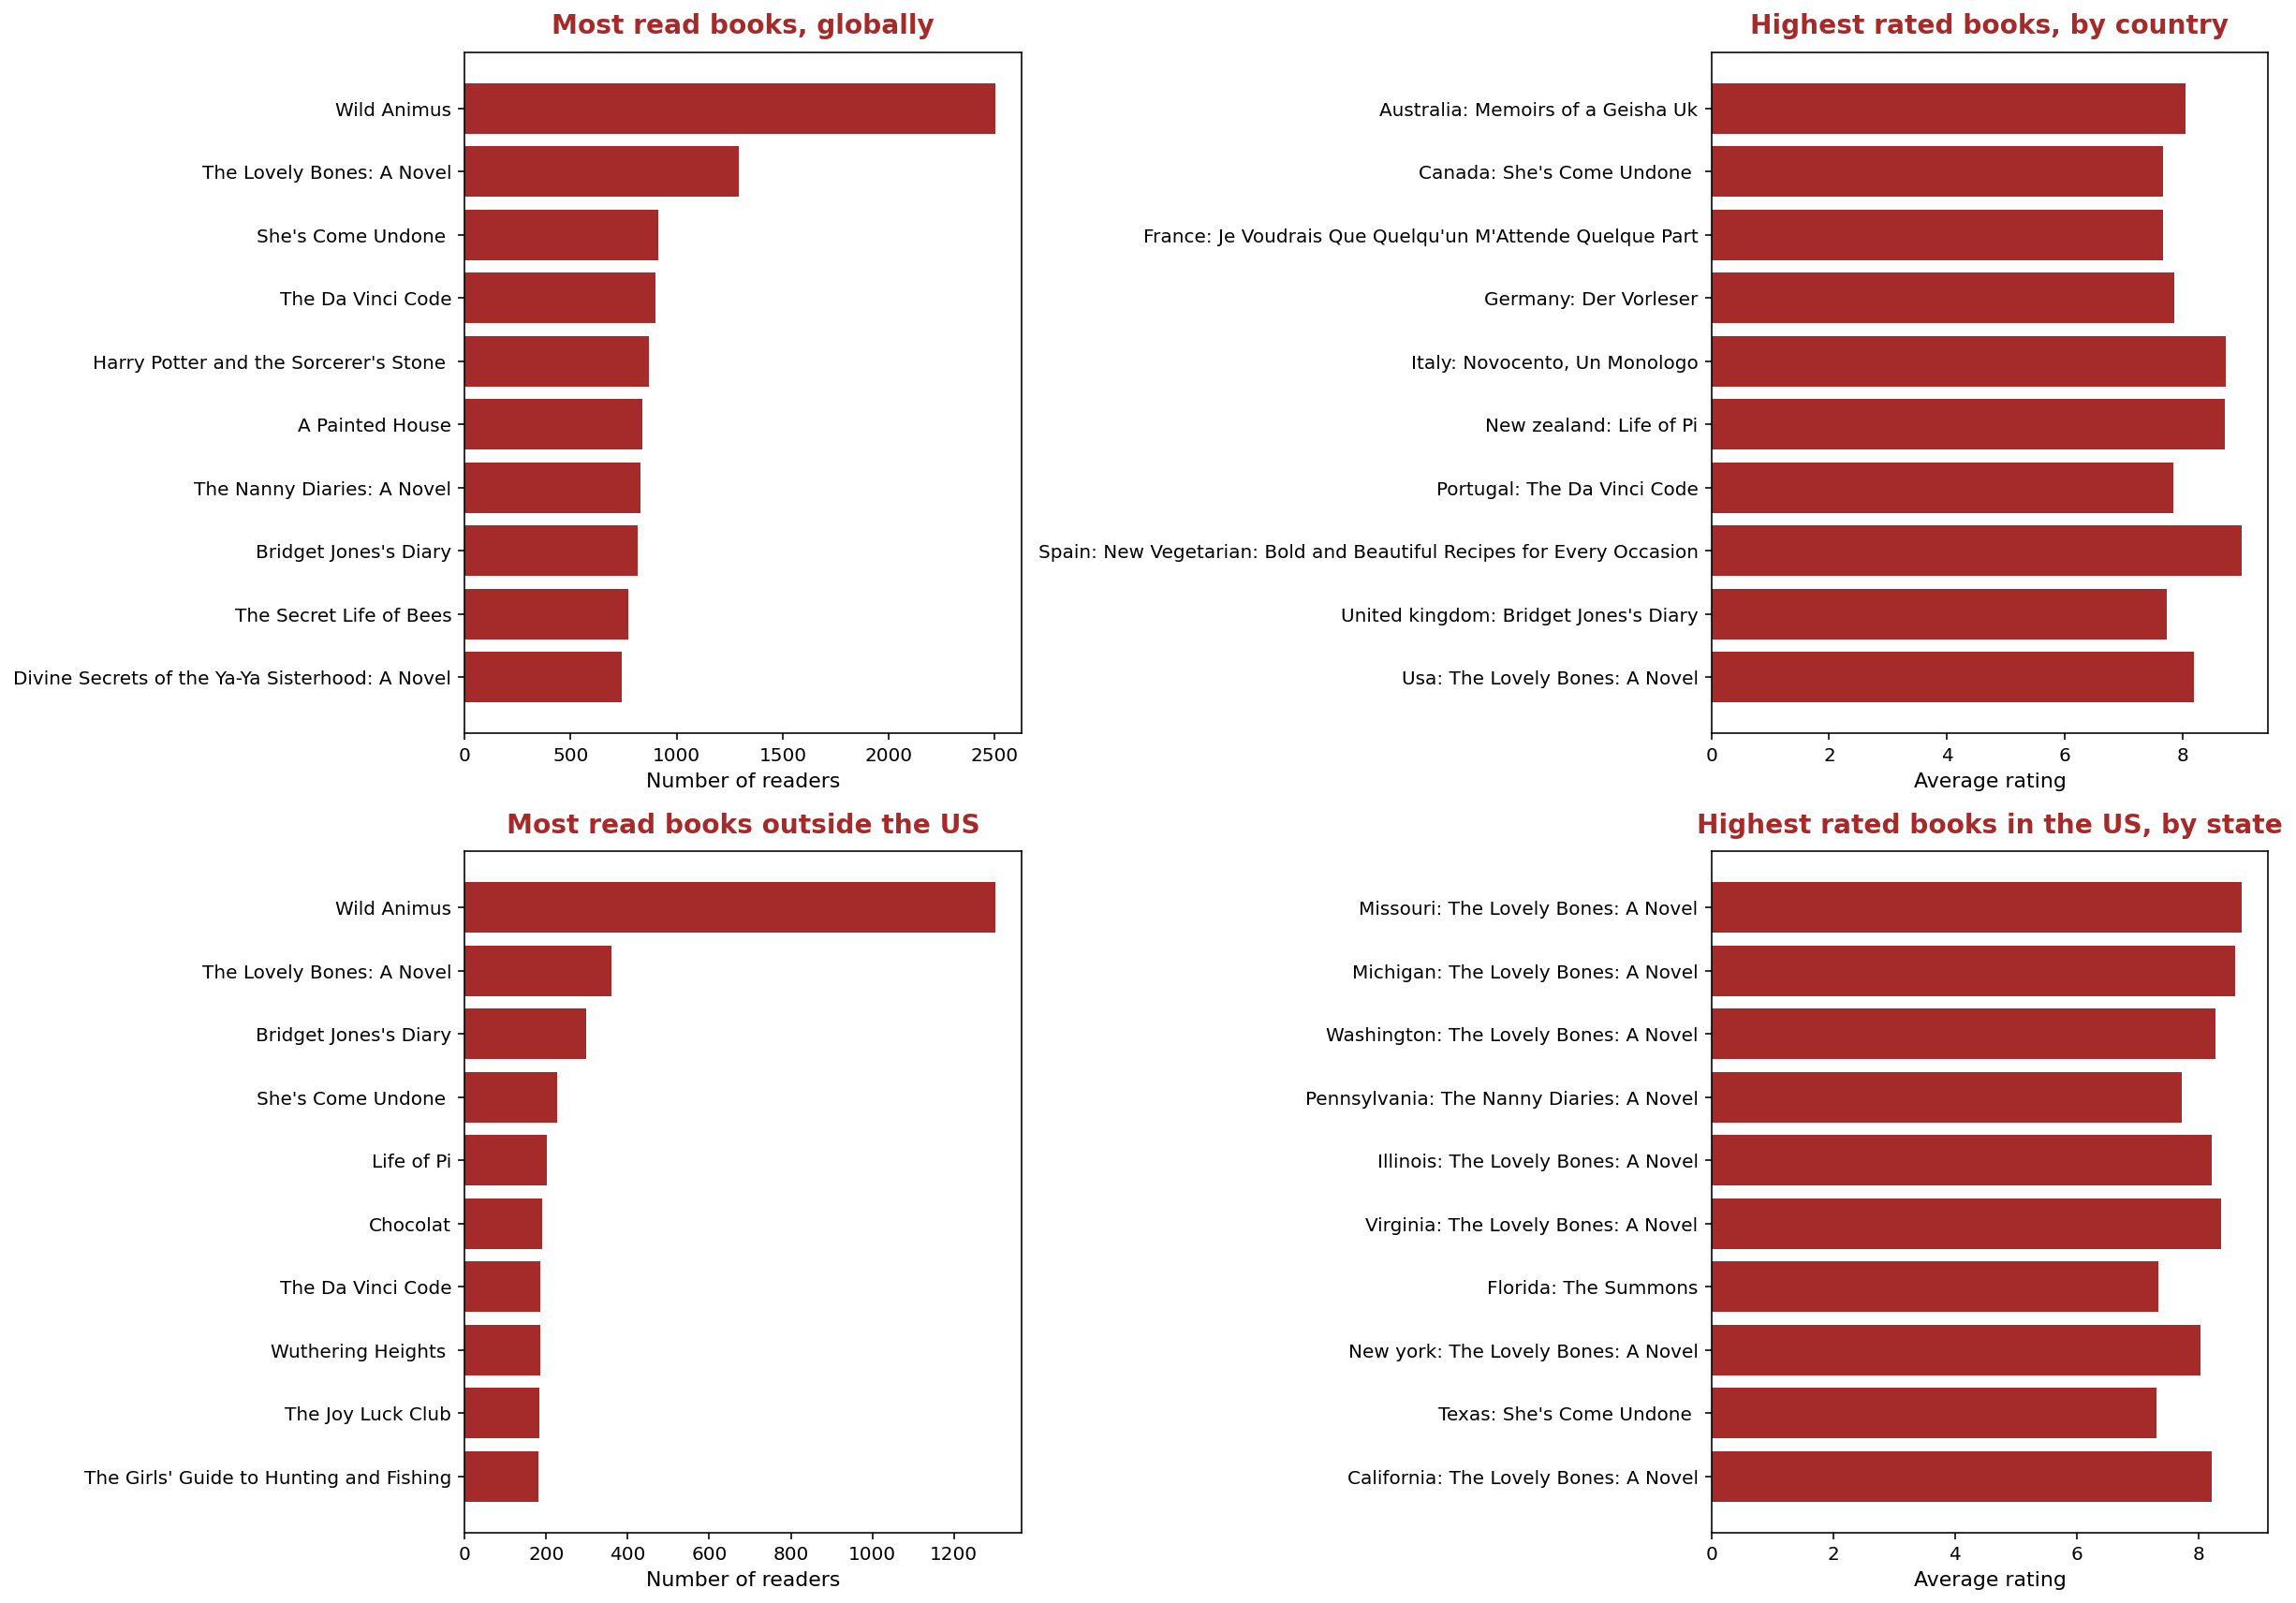

In [27]:
plt.figure(figsize=(17,12))
plt.subplot(2,2,1)
plt.title('Most read books, globally', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.barh(range(10), sorted(most_read_global['Read-By'], reverse=False)[-10:], color = 'brown')
plt.xlabel('Number of readers', fontdict = {'fontsize': 11})
plt.yticks(range(10), most_read_global.sort_values('Read-By')['Book-Title'][-10:])
plt.subplot(2,2,2)
plt.title('Highest rated books, by country', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.barh(range(10), highest_rated_by_cntry['Avg-Rating'], color = 'brown')
plt.xlabel('Average rating', fontdict = {'fontsize': 11})
plt.yticks(range(10), [c+': '+t for c, t in zip([c.capitalize() for c in highest_rated_by_cntry['Country']], highest_rated_by_cntry['Book-Title'])])
plt.subplot(2,2,3)
plt.title('Most read books outside the US', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.barh(range(10), sorted(most_read_not_us['Read-By'], reverse=False)[-10:], color = 'brown')
plt.yticks(range(10), most_read_not_us.sort_values('Read-By')['Book-Title'][-10:])
plt.xlabel('Number of readers', fontdict = {'fontsize': 11})
plt.subplot(2,2,4)
plt.title('Highest rated books in the US, by state', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
plt.barh(range(10), highest_rated_by_state['Avg-Rating'][:10], color = 'brown')
plt.xlabel('Average rating', fontdict = {'fontsize': 11})
plt.yticks(range(10), [s+': '+t for s, t in zip([s.capitalize() for s in highest_rated_by_state['State'][:10]], highest_rated_by_state['Book-Title'][:10])])

plt.tight_layout();

Very few of the books which are popular in the US are also popular elsewhere, although "Wild Animus" tops both lists.<br>
Tastes (as reflected by higest rated books) vary widely between countries but not much among the shown US states, where "The Lovely Bones" leads most of the ranks.

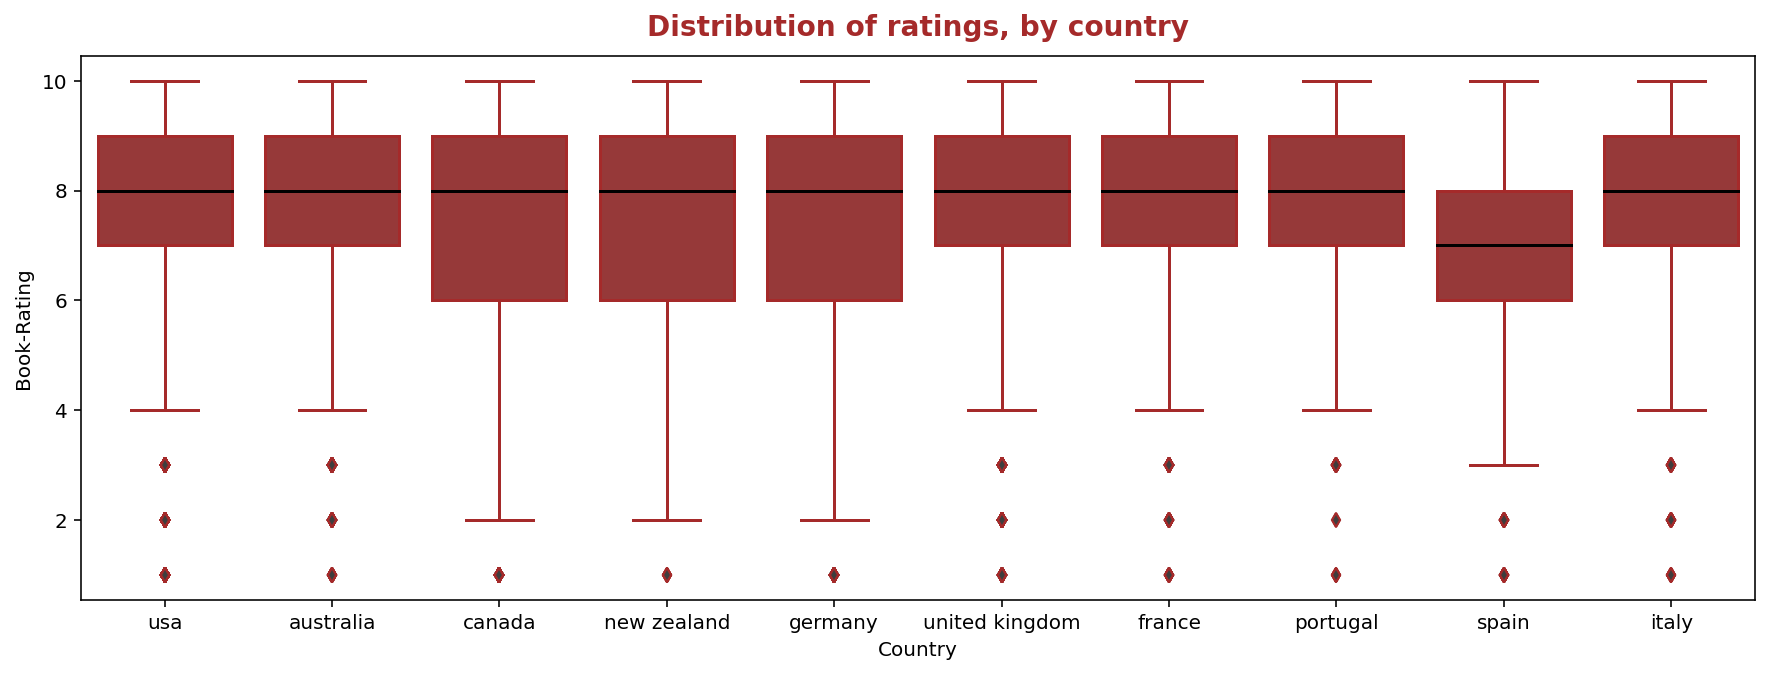

In [28]:
plt.figure(figsize = (15,5))
plt.title('Distribution of ratings, by country', fontdict= {'fontsize': 14, 'fontweight' : 'bold', 'color' : 'brown'}, pad= 10)
sns.boxplot(x = ratings_w_info[ratings_w_info['Country'].isin(top10_countries)]['Country'], y = ratings_w_info[ratings_w_info['Country'].isin(top10_countries)]['Book-Rating'], color = 'brown',
           boxprops=dict(edgecolor='brown'), capprops=dict(color='brown'), whiskerprops=dict(color='brown'), flierprops=dict(color='brown', markeredgecolor='brown'),
            meanprops = dict(color = 'black', ls = '--'),medianprops=dict(color='black'), );

Spanish readers appear to be the toughest critics among the top ten countries.

In [29]:
print(f"{sum([1 for book in ratings['ISBN'].unique() if not book in books.index])} of all {ratings['ISBN'].nunique()} books that are listed in the ratings dataset are not represtented in the books dataset.")
print(f"{sum([1 for user in ratings['User-ID'].unique() if not int(user) in users.index])} of all {ratings['User-ID'].nunique()} users that are listed in the ratings dataset are not represtented in the users dataset.")

70405 of all 340556 books that are listed in the ratings dataset are not represtented in the books dataset.
0 of all 105283 users that are listed in the ratings dataset are not represtented in the users dataset.


In [30]:
ratings = ratings[ratings['ISBN'].isin(books.index)] # reducing the ratings dataset to match books with iformation

#### Finding book info by ISBN

In [31]:
def what_book(isbn):
    print(f"This book is '{books.loc[isbn, 'Book-Title']}' by {books.loc[isbn, 'Book-Author']}, published in {books.loc[isbn, 'Year-Of-Publication']} by {books.loc[isbn, 'Publisher']}.")
    return books.loc[isbn, 'Book-Title'], books.loc[isbn, 'Book-Author'], books.loc[isbn, 'Year-Of-Publication'], books.loc[isbn, 'Publisher']

In [32]:
what_book('0374157065')

This book is 'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It' by Gina Bari Kolata, published in 1999 by Farrar Straus Giroux.


('Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It',
 'Gina Bari Kolata',
 '1999',
 'Farrar Straus Giroux')

## 3. Recommendations

#### 3.1. Converting ratings from a table to a Users x Books matrix

Because the dataset is large and computing the users x books pivot table is a problem, I am building such matrix only for most read books and most active users:

In [35]:
cnt_by_isbn = ratings.groupby('ISBN')['Book-Rating'].count().reset_index()
isbns = cnt_by_isbn[cnt_by_isbn['Book-Rating']> cnt_by_isbn['Book-Rating'].quantile(0.8)]['ISBN'] # books in the top 80% in terms of ratings received

cnt_by_uid = ratings.groupby('User-ID')['Book-Rating'].count().reset_index() 
users = cnt_by_uid[cnt_by_uid['Book-Rating']> cnt_by_uid['Book-Rating'].quantile(0.8)]['User-ID'] # users in the top 80% in terms of ratings provided

In [37]:
ratings_pareto = ratings[(ratings['ISBN'].isin(isbns)) & (ratings['User-ID'].isin(users))]

In [38]:
ratings_pareto.shape

(549914, 3)

In [74]:
ratings = ratings_pareto # overriding ratings with the pareto created above (can be commented out to easily switch to full ratings in faster environments)

In [40]:
ur_matrix = ratings.pivot_table(index = 'User-ID', columns = 'ISBN', values = 'Book-Rating')

In [41]:
ur_matrix.head()

ISBN,0001047973,000104799X,0001048082,0001056107,0002005018,0002006588,0002116286,0002118580,0002153572,0002176432,...,9879402219,987960170X,9993584185,B00005U7YK,B00005UMK6,B0000633PU,B00009EF82,B00009NDAN,B0000E63CJ,B0001GMSV2
User-ID,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.2. Finding similar users

A function that calculates hamming distance between two users:

In [42]:
def distance_users(user1, user2): 
    user1vec = ur_matrix[ur_matrix.index == user1] # extracting the vector corresponding to ratings by user1
    user2vec = ur_matrix[ur_matrix.index == user2] # extracting the vector corresponding to ratings by user2
    distance_den = ur_matrix.shape[1] # the denominator of normalized distance (number of books users could have rated)
    distance_nom = ur_matrix.shape[1]  # the starting value of nominator of normalized distance
    for _ in range(ur_matrix.shape[1]): # for all books in the dataset:
        try:
            if user1vec[_] == user2vec[_]: # if rating matches between the compared users
                distance_nom -= 1          # reduce nominator by 1
            elif user1vec[_].isna() and user2vec[_].isna(): # if there is no rating from both users for the same book
                distance_nom -= 1                           # also reduce nominator by 1
            else:
                pass                                        # otherwise don't reduce
        except:
            pass
    return distance_nom/distance_den # calculate nominator : denominator

In [43]:
distance_users(255489, 204622)

1.0

A function that finds n users that are similar to a given user, using the definiton of distance from above:

In [45]:
def find_n_similar(user, n): 
    distances = {}
    for other_user in ur_matrix.index: # loop through all users in the user-ratings matrix (switch from ur_matrix to ur_matrix_slim for testing because it took too long to run the function on the entire set of users
        if other_user == user:         # skip the user in question 
            pass
        else:                          # calculate distances for all others and add them to the `distances` dict
            distances[other_user] = distance_users(user, other_user)
    distances_df = pd.DataFrame(data = distances.values(), index = distances.keys(), columns = ['dist']).sort_values(['dist']) # put users and distances into a dataframe, sorted by distance, from smallest to largest
            
    return list(distances_df.head(n).index) # return list of id's for n most similar users

In [46]:
find_n_similar(225433,10)

[8, 184310, 184319, 184348, 184354, 184365, 184386, 184401, 184424, 184465]

#### 3.3. Collaborative Filtering Recommendations: Nearest Neighbors

In [47]:
# a function which finds m books that a given user is likely to enjoy, based on ratings on n most similar users
def find_m_recommendations(user, n, m):
    books_read = list(ur_matrix[ur_matrix.index == user].dropna(axis = 1).columns) # finding books the user has alread read, to not repeat them in recommendations
    similar_users = find_n_similar(user, n) # applying the function defined above to find the reference group
    #similar_users = [211307, 208786, 262635, 26435, 46862, 215094, 131884, 203491, 89558, 4221]
    avg_ratings = ur_matrix[ur_matrix.index.isin(similar_users)].aggregate(['mean']).drop(columns = books_read) # calculating mean rating of books not read by user provided by most similar users
    avg_ratings_sorted = avg_ratings.T.sort_values('mean', ascending = False) # sorting books by rating (high to low)
    top_m = avg_ratings_sorted.index[:m] # selecting top m books
    m_books = books[books.index.isin(top_m)][['Book-Title', 'Book-Author']] # pulling in title and author from `books` dataframe
    return m_books

In [48]:
find_m_recommendations(225433, 3, 10)

,Book-Title,Book-Author
ISBN,,


#### 3.4. Collaborative Filtering Recommendations: Latent Factors

Ratings are converted to a sparse matrix after the dimensions (users and book ISBNs) are set as categorical data: 

In [49]:
ratings['User-ID'] = ratings['User-ID'].astype('category')
ratings['ISBN'] = ratings['ISBN'].astype('category')

In [50]:
ratings_mtrx = coo_matrix((ratings['Book-Rating'].astype(float), (ratings['User-ID'].cat.codes.copy(), ratings['ISBN'].cat.codes.copy())))

In [51]:
print(f"The sparse matrix has {ratings_mtrx.shape[0]} rows and {ratings_mtrx.shape[1]} columns, representing {ratings['User-ID'].nunique()} users and {ratings['ISBN'].nunique()} books.")

The sparse matrix has 15553 rows and 49856 columns, representing 15553 users and 49856 books.


To set up collaborative filtering, I first create a users-factors and a factors-books matrix filled with random numbers:

In [52]:
num_usrs = ratings_mtrx.shape[0]
num_bks = ratings_mtrx.shape[1]
num_ftrs = 3

In [53]:
usrs_fctr_mtrx = np.random.rand(num_usrs, num_ftrs)
fctr_bks_mtrx = np.random.rand(num_ftrs, num_bks)

The random numbers are replaced with calculated values so as to minimize the error between real ratings and ratings calculated from the two matrices above:

In [54]:
def est_error(ratings_matrix, users_factor_matrix, factor_books_mtrx, l = 0.05):
    ratings = ratings_matrix.data # transforming the input ratings matrix into a vector
    rrows = ratings_matrix.row # row index array of the matrix
    rcols = ratings_matrix.col # column index array of the matrix
    err = 0 # initiating total error at zero
    for uir in range(len(ratings)): # for each position in the matrix:
        rtg_ui = ratings[uir]       # find the value of corresponding rating
        usr = rrows[uir]            # find the row corresponding to the user
        bk = rcols[uir]             # find the column corresponding to the book
        if rtg_ui>0:                # if the value of rating is not zero:
            err = err + (rtg_ui - np.dot(users_factor_matrix[usr,:], 
                                         factor_books_mtrx[:,bk]))**2 + l * (norm(users_factor_matrix[usr,:])**2 + norm(factor_books_mtrx[:,bk])**2)
                                    # calculate the difference btw rating and calculated rating, and increase calculated total error by the corresponding value
    
    return err

In [55]:
rmse = np.sqrt(est_error(ratings_mtrx, usrs_fctr_mtrx, fctr_bks_mtrx)/len(ratings_mtrx.data))

In [56]:
rmse

4.646060083435734

Applying stochastic gradient descent to find a set of user-factor and factor-item matrices which reduce the total error of calculated ratings:

In [57]:
def min_error(ratings_mtrx, num_ftrs, tgt_err, l = 0.05, g = 0.001, steps = 2): 
    num_usrs, num_bks = ratings_mtrx.shape                  # unpack shape into two variables representing the number of users and number of items (books)
    ratings = ratings_mtrx.data                             # conver ratings matrix into a vector
    rrows = ratings_mtrx.row                                # row index array of the matrix
    rcols = ratings_mtrx.col                                # column index array of the matrix
    usrs_fctr_mtrx = np.random.rand(num_usrs, num_ftrs)     # create a user-factors matrix with correct dimensions and random values
    fctr_bks_mtrx = np.random.rand(num_ftrs, num_bks)       # create a factors-items matrix with correct dimensions and random values
    rmse = np.sqrt(est_error(ratings_mtrx, usrs_fctr_mtrx, fctr_bks_mtrx)/len(ratings_mtrx.data)) # calculate RMSE
    print(f"Initial RMSE = {round(rmse, 4)}")
    for step in range(steps):           # in each iteration (step)
        for uir in range(len(ratings)): # for each rating value
            rtg_ui = ratings[uir]       # find the value of corresponding rating
            usr = rrows[uir]            # find the row corresponding to the user
            bk = rcols[uir]             # find the column corresponding to the book
            if rtg_ui>0:                # if the value of rating is not zero:
                err_ui = rtg_ui - np.dot(usrs_fctr_mtrx[usr,:], fctr_bks_mtrx[:,bk]) # calculate error of the individual rating
                usrs_fctr_mtrx[usr,:] = usrs_fctr_mtrx[usr,:]+ 2*g*(err_ui*fctr_bks_mtrx[:,bk] - l*usrs_fctr_mtrx[usr,:]) # increment values in users fators matrix
                fctr_bks_mtrx[:,bk] = fctr_bks_mtrx[:,bk] + 2*g*(err_ui*usrs_fctr_mtrx[usr,:] - l*fctr_bks_mtrx[:,bk]) # increment values in fators-books matrix
        rmse = np.sqrt(est_error(ratings_mtrx, usrs_fctr_mtrx, fctr_bks_mtrx)/len(ratings_mtrx.data)) # calculating updated RMSE
        if rmse <= tgt_err: # if RMSE is below rarget, break function
            break
    print(f"Final RMSE = {round(rmse,4)}")
    return usrs_fctr_mtrx, fctr_bks_mtrx

In [58]:
ufm, fbm = min_error(ratings_mtrx, 3, 0.7, steps = 100)

Initial RMSE = 4.6422
Final RMSE = 0.955


In [59]:
ufm

array([[0.63131026, 1.54676438, 1.61288352],
       [0.93259551, 1.0297672 , 1.69039208],
       [2.25947672, 1.86241098, 0.31184574],
       ...,
       [2.34361196, 1.58389836, 2.10583512],
       [1.47295323, 2.02602947, 1.62157262],
       [2.1118737 , 1.75644119, 1.67534759]])

In [60]:
fbm

array([[1.28701799, 1.36965078, 0.89210421, ..., 1.07076091, 0.88420364,
        0.96894785],
       [1.35355446, 0.83043233, 1.06588659, ..., 1.65257486, 1.47581968,
        1.68089628],
       [1.72152538, 1.41262979, 1.58017866, ..., 1.50765809, 1.17691249,
        0.7900225 ]])

In [61]:
ufm.shape

(15553, 3)

In [62]:
fbm.shape

(3, 49856)

In [63]:
ratings_mtrx.shape

(15553, 49856)

In [64]:
ratings['User-ID'].unique()[np.random.randint(0,15500)]

258139

Finally, the user-factors and factors-books matrices are used to generate recommendations for a user:

In [65]:
def find_n_recommendations(user_id, n):
    row = list(ratings['User-ID'].unique()).index(user_id) # determining which row in the user-factor matrix corresponds to user_id
    read = list(ratings[(ratings['User-ID'] == user_id) & (ratings['Book-Rating']>0)]['ISBN']) # determining which books the user has read, so as to not recommend them again
    bk_rtngs = np.dot(ufm[row], fbm) # calculating user ratings for all books in the library
    bks = pd.DataFrame(index = ratings['ISBN'].unique(), columns = ['rating'], data = bk_rtngs.transpose()).sort_values(['rating'], ascending = False) # sorting books by rating
    unrd_bks = bks[~bks.index.isin(read)]
    unrd_bks = unrd_bks.merge(books[['Book-Title', 'Book-Author']], left_index = True, right_index = True).drop(['rating'], axis = 1) # pulling in the titles and authors to display
    return unrd_bks.head(n), read

Spot-check to make sure that the algorithm correctly extracts ratings from the user-ratings matrix:

In [66]:
ratings_mtrx_arr = ratings_mtrx.toarray()

In [67]:
ratings[(ratings['User-ID']==264892) & (ratings['ISBN']=='0373226705')]

,User-ID,ISBN,Book-Rating
1103243,264892,0373226705,6.0


In [68]:
ratings_mtrx_arr[sorted(ratings['User-ID'].unique()).index(264892)][sorted(ratings['ISBN'].unique()).index('0373226705')]

6.0

Testing the algorithm on user_id = 264892:

In [69]:
recs, read = find_n_recommendations(264892,10)
recs

,Book-Title,Book-Author
0743407059,The First Time,Joy Fielding
0807081035,Grandmothers of the Light: A Medicine Woman's ...,Paula Gunn Allen
3426602865,Mein Jahr in der Provence / Toujours Provence.,Peter Mayle
1889392006,Baby Bargains: Secrets to Saving 20% to 50% on...,Denise Fields
0684163403,A Gathering of Days : A New England Girl's Jou...,Joan W. Blos
0877956324,Glitz,Elmore Leonard
1855383446,Introducing Neuro-Linguistic Programming: Psyc...,Joseph O'Conner
0804110867,Other People's Skeletons,Julie Smith
0761122710,Chocolate from the Cake Mix Doctor,Anne Byrn
0373613733,A Verdict of Love,Jenna Mills


In [70]:
books[books.index.isin(read)]

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
ISBN,,,,,,,
0441005489,Redwall,Brian Jacques,1998,Ace Books,http://images.amazon.com/images/P/0441005489.0...,http://images.amazon.com/images/P/0441005489.0...,http://images.amazon.com/images/P/0441005489.0...
0679724362,The Road from Coorain,Jill Ker Conway,1990,Vintage Books USA,http://images.amazon.com/images/P/0679724362.0...,http://images.amazon.com/images/P/0679724362.0...,http://images.amazon.com/images/P/0679724362.0...
0553292307,"STOLEN DIARY, THE",FRANCINE PASCAL,1992,Sweet Valley,http://images.amazon.com/images/P/0553292307.0...,http://images.amazon.com/images/P/0553292307.0...,http://images.amazon.com/images/P/0553292307.0...
0918273838,Donald Duk: A Novel,Frank Chin,1991,Coffee House Press,http://images.amazon.com/images/P/0918273838.0...,http://images.amazon.com/images/P/0918273838.0...,http://images.amazon.com/images/P/0918273838.0...
0373226705,Not On His Watch,Cassie Miles,2002,Harlequin,http://images.amazon.com/images/P/0373226705.0...,http://images.amazon.com/images/P/0373226705.0...,http://images.amazon.com/images/P/0373226705.0...


In [71]:
ratings[(ratings['ISBN'].isin(read)) & (ratings['User-ID']== 264892)] # actual ratings by user 264892

,User-ID,ISBN,Book-Rating
1103243,264892,0373226705,6.0
1103244,264892,0441005489,7.0
1103245,264892,0553292307,5.0
1103246,264892,0679724362,8.0
1103247,264892,0918273838,6.0


A modified version of the find_n_recommendations algorithm to check if it would recommend previously read and highly rated books:

In [72]:
def check_n_recommendations(user_id, n):
    row = list(ratings['User-ID'].unique()).index(user_id) # determining which row in the user-factor matrix corresponds to user_id
    bk_rtngs = np.dot(ufm[row], fbm) # calculating user ratings for all books in the library
    bks = pd.DataFrame(index = ratings['ISBN'].unique(), columns = ['rating'], data = bk_rtngs.transpose()).sort_values(['rating'], ascending = False) # sorting books by rating
    bks = bks.merge(books[['Book-Title', 'Book-Author']], left_index = True, right_index = True) # pulling in the titles and authors to display
    return bks.head(n)

In [73]:
check_n_recommendations(264892,10)

,rating,Book-Title,Book-Author
0743407059,7.824967,The First Time,Joy Fielding
0807081035,7.540201,Grandmothers of the Light: A Medicine Woman's ...,Paula Gunn Allen
3426602865,7.537378,Mein Jahr in der Provence / Toujours Provence.,Peter Mayle
1889392006,7.536345,Baby Bargains: Secrets to Saving 20% to 50% on...,Denise Fields
0684163403,7.349839,A Gathering of Days : A New England Girl's Jou...,Joan W. Blos
0877956324,7.344740,Glitz,Elmore Leonard
1855383446,7.323788,Introducing Neuro-Linguistic Programming: Psyc...,Joseph O'Conner
0804110867,7.321208,Other People's Skeletons,Julie Smith
0761122710,7.319146,Chocolate from the Cake Mix Doctor,Anne Byrn
0373613733,7.271442,A Verdict of Love,Jenna Mills


None of the books the user has read and rated are included among the recommendations, meaning the algorithm should probably be further refined.